### Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import numpy as np
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
import umap
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2023-10-10 03:38:30.856133: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-10 03:38:30.919002: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/local/lib/python3.8/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mo

2.12.0


In [2]:
## Uso de GPU
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

## Datos

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
rutas_dataset  = glob.glob('/home/willy98/archivos/Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:
    ruta_list = ruta.split('/')
    clase = ruta_list[7]
    number = ruta_list[8]
    tipo = ruta_list[9]
    name = ruta_list[10].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','class','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','class','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','class','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(routes_dataset[routes_dataset['class']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['class'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 927
MF1: - secas:  378
MF2: - secas:  288
MF3: - secas:  261


,name,route_image,class,number,route_mask
2,IMG_20230601_151622_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,1,/home/willy98/archivos/Datasets/Micrografías_s...
189,IMG_20230707_164535_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
120,IMG_20230707_162026_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
0,IMG_20230601_151551_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,1,/home/willy98/archivos/Datasets/Micrografías_s...
11,IMG_20230601_151932_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,1,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
782,IMG_20230711_211139_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,2,2,/home/willy98/archivos/Datasets/Micrografías_s...
413,IMG_20230707_185215_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,6,/home/willy98/archivos/Datasets/Micrografías_s...
331,IMG_20230707_180559_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,5,/home/willy98/archivos/Datasets/Micrografías_s...
237,IMG_20230707_171059_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,3,/home/willy98/archivos/Datasets/Micrografías_s...


In [4]:
## Establecer el porcentaje de separación
prct_train = 0.8

thold1 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='0'])))
thold2 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='1'])))
thold3 = int(np.ceil(prct_train * len(routes_dataset[routes_dataset['class']=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset['class'] == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset['class'] == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset['class'] == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset['class'] == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset['class'] == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset['class'] == '2'][thold3:]

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  231 , test:  57
Clase MF3: train:  209 , test:  52


In [7]:
### Definir datasets de training y test
# Todas las clases
#train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3])
#test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3])

# solo una clase
train_df = train_cu1
test_df = test_cu1

train_df

,name,route_image,class,number,route_mask
189,IMG_20230707_164535_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
120,IMG_20230707_162026_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
344,IMG_20230707_180751_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,5,/home/willy98/archivos/Datasets/Micrografías_s...
97,IMG_20230707_161404_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
102,IMG_20230707_161741_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,1,/home/willy98/archivos/Datasets/Micrografías_s...
...,...,...,...,...,...
223,IMG_20230707_170914_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,3,/home/willy98/archivos/Datasets/Micrografías_s...
172,IMG_20230707_164332_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,2,/home/willy98/archivos/Datasets/Micrografías_s...
270,IMG_20230707_173648_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,4,/home/willy98/archivos/Datasets/Micrografías_s...
411,IMG_20230707_185202_jpg,/home/willy98/archivos/Datasets/Micrografías_s...,0,6,/home/willy98/archivos/Datasets/Micrografías_s...


In [8]:
## Crear objetos transformadores
## Para entrenamiento
SEED = 100

img_generator_images = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

img_generator_mask = tf.keras.preprocessing.image.ImageDataGenerator(  
    rescale=1./255,      
    horizontal_flip=True,
    vertical_flip=True,
    validation_split=0.2
)

## Crear objeto generador de imágenes a partir del objeto transformator
## Pra entrenamiento
train_generator_IMAGES = img_generator_images.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_image",
    y_col="class",
    labels = ['MF1'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

train_generator_MASK = img_generator_mask.flow_from_dataframe(
    dataframe=train_df,
    #directory="./train/",
    x_col="route_mask",
    y_col="class",
    labels = ['MF1'],
    #labels = ['MF2'],
    subset="training",
    batch_size=64,
    seed=SEED,
    shuffle=True,
    class_mode="sparse" ,
    validation_split=0.2,
    color_mode ="grayscale",
    target_size=(128,128))

Found 243 validated image filenames belonging to 1 classes.
Found 243 validated image filenames belonging to 1 classes.


In [9]:
X_train_images = []
train_mask = []
label_train_images  = []
label_train_mask = []

batches = 50
cnt = 0

for i in range(batches):
    
    x,y = train_generator_IMAGES.next()

    X_train_images.extend(x)
    label_train_images.extend(y)
    
for i in range(batches):
    
    x,y = train_generator_MASK.next()

    train_mask.extend(x)
    label_train_mask.extend(y)
    
    
print(np.shape(train_mask),np.shape(train_mask))
print(np.array_equal(label_train_mask,label_train_images))

(3044, 128, 128, 1) (3044, 128, 128, 1)
True


0.0 0.0


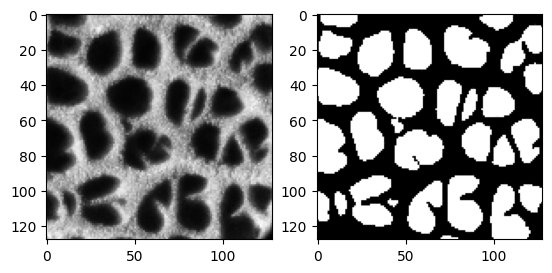

In [10]:
## Visualizar:
n = 0
fig, (ax1, ax2) = plt.subplots(1, 2)
ax2.imshow(train_mask[n],cmap='gray')
ax1.imshow(X_train_images[n],cmap='gray')
print(label_train_mask[n],label_train_images[n])
plt.show()

In [11]:
x_train_images = np.array(X_train_images)

x_train_images = x_train_images.astype('float32')

print('x_train shape:', x_train_images.shape)
print('Number of images in x_train', x_train_images.shape[0])

x_train shape: (3044, 128, 128, 1)
Number of images in x_train 3044


## Modelo

In [16]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

class VAE(keras.Model):
    def __init__(self,encoder,decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        ##Variables que guardan paso a paso las pérdidas
        self.kl_loss_tracker = keras.metrics.Mean(name='kl_loss')        
        self.reconstruction_loss_tracker = keras.metrics.Mean(name='reconstruction_loss')
        self.total_loss_tracker = keras.metrics.Mean(name='total_loss')
        
    @property
    def metrics(self):
        return[
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def train_step(self,data):
        with tf.GradientTape() as tape:
            ## Generar embebidos
            z_mean, z_log_var, z = self.encoder(data)
            
            ## Reconstruir embebidos
            reconstruction = self.decoder(z)
            
            ## Normalizar reconstrucciones
            reconstruction /= tf.reduce_max(reconstruction)
            
            ## Calcular la diferencia binaria entre las imágenes de entrada y las reconstrucciones
            
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )         
            
            '''
            reconstruction_loss =tf.reduce_mean(
                tf.reduce_sum( tf.keras.losses.MeanSquaredError()(data, reconstruction)
                             )
            )
            '''
            
            ## Pérdida de kullback leibler
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))            
        
            ## Pérdida total
            total_loss = reconstruction_loss + kl_loss     
            
        ## Calcular los gradientes 
        grads = tape.gradient(total_loss, self.trainable_weights)       

        ## Guardar reconstrucciones en una variable propia del modelo
        self.reconstruction = reconstruction

        ## Calcular gradientes entre los pesos            
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))

        ## Actualizar la variable de pérdida total
        self.total_loss_tracker.update_state(total_loss)

        ## Actualizar la variable de pérdida de reconstrucción
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)       

        ## Actualizar la variable de pérdida por kull-back
        self.kl_loss_tracker.update_state(kl_loss)       

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(), 
            'kl_loss':self.kl_loss_tracker.result(),
        }

In [17]:
### Encoder
latent_dim = 128

encoder_inputs = keras.Input(shape=(128, 128, 1))

x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',name='layer_E1')(encoder_inputs)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same',name='layer_E3')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same',name='layer_E2')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same',name='layer_E4')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same',name='layer_E6')(x)
x = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', padding='same',name='layer_E7')(x)
x = layers.Flatten()(x)



z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(inputs=encoder_inputs, outputs=[z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 layer_E1 (Conv2D)              (None, 128, 128, 10  10240       ['input_3[0][0]']                
                                24)                                                               
                                                                                                  
 max_pooling2d_5 (MaxPooling2D)  (None, 64, 64, 1024  0          ['layer_E1[0][0]']               
                                )                                                           

In [18]:
### Decoder
## Entrada Z
latent_inputs = keras.Input(shape=(latent_dim,))

##dimensiones
ndim = 8
nfilts = 128

## anti-flatten de la última capa convolucional
x = layers.Dense(ndim * ndim * nfilts, activation="relu")(latent_inputs)

## Reshape para reconstruir la última convolucional
x = layers.Reshape((ndim,ndim, nfilts))(x)

## Capas convolucionales
x = tf.keras.layers.Conv2D(nfilts, (3, 3), activation='relu', padding='same',name='layer_D1')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/2, (3, 3), activation='relu', padding='same',name='layer_D2')(x)
x = tf.keras.layers.UpSampling2D((2, 2))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/4, (3, 3), activation='relu', padding='same',name='layer_D4')(x)
x = tf.keras.layers.UpSampling2D((4, 4))(x)
x = tf.keras.layers.BatchNormalization()(x)

x = tf.keras.layers.Conv2D(nfilts/8, (3, 3), activation='relu', padding='same',name='layer_D6')(x)

decoder_outputs = tf.keras.layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same',name='layer_D7')(x)

## Construcción del decoder
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128)]             0         
                                                                 
 dense_1 (Dense)             (None, 8192)              1056768   
                                                                 
 reshape_1 (Reshape)         (None, 8, 8, 128)         0         
                                                                 
 layer_D1 (Conv2D)           (None, 8, 8, 128)         147584    
                                                                 
 up_sampling2d_3 (UpSampling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization_13 (Bat  (None, 16, 16, 128)      512       
 chNormalization)                                          

In [ ]:
vae = VAE(encoder, decoder)
opt = tf.optimizers.Adam(learning_rate = 0.00001)
#nll = lambda x , rv_x: -rv_x.log_prob(x)
vae.compile(optimizer=opt)


vae.fit(x_train_images, epochs=2000, 
                batch_size=16,
                         callbacks=[tf.keras.callbacks.EarlyStopping(monitor='loss', patience=75)])

Epoch 1/2000
191/191 [==============================] - 22s 78ms/step - loss: 30039.6497 - reconstruction_loss: 26751.5684 - kl_loss: 0.1392
Epoch 2/2000
191/191 [==============================] - 15s 78ms/step - loss: 14657.7727 - reconstruction_loss: 12476.9121 - kl_loss: 353.9059
Epoch 3/2000
191/191 [==============================] - 15s 77ms/step - loss: 11587.6129 - reconstruction_loss: 11221.0928 - kl_loss: 276.5345
Epoch 4/2000
191/191 [==============================] - 15s 77ms/step - loss: 11253.4104 - reconstruction_loss: 10998.9961 - kl_loss: 203.9331
Epoch 5/2000
191/191 [==============================] - 15s 78ms/step - loss: 11062.4763 - reconstruction_loss: 10851.8916 - kl_loss: 162.8909
Epoch 6/2000
191/191 [==============================] - 15s 78ms/step - loss: 10910.8379 - reconstruction_loss: 10742.5820 - kl_loss: 136.8567
Epoch 7/2000
191/191 [==============================] - 15s 77ms/step - loss: 10753.4447 - reconstruction_loss: 10626.7139 - kl_loss: 108.3370
E

In [ ]:
vae.encoder.save('Models/GVAE_DRY_MF1_128_1_FULL_DATA_encoder.h5')
vae.decoder.save('Models/GVAE_DRY_MF1_128_1_FULL_DATA_decoder.h5')